# Tech Challenge Fase 4
## Prevendo os valores futuros do petróleo Brent
Membros do grupo 24:

- Carol - carol
- Gustavo França Severino - gustavofs.dt@gmail.com
- Frederico Garcia Costa - fredgcosta@gmail.com
- Jeferson Vieira - jvieirax@gmail.com
- Victor Wilson Costa Lamana - victor.lamana15@gmail.com

Neste notebook iremos realizar uma análise da série temporal do petróleo Brent e propor uma estratégia para a previsão dos valores futuros. Iremos utilizar as bibliotecas TensorFlow e Keras para a criação dos modelos.

## Importando as bibliotecas necessárias

In [1]:
import os
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
keras = tf.keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['font.size'] = 12

In [2]:
print("Quantidade de GPUs disponíveis: ", len(tf.config.list_physical_devices('GPU')))

Quantidade de GPUs disponíveis:  1


## Obtendo os Dados do petróleo Brent
Utilizamos a biblioteca yfinance para facilitar o download dos dados do site Yahoo! Finance. Utilizamos o símbolo do petróleo Brent (BZ=F) e o intervalo de 01/01/2020 até 01/05/2024.

In [3]:
brent = pd.read_csv('Europe_Brent_Spot_Price_FOB.csv', parse_dates=True, index_col=0)
brent = brent.sort_values(by='Date', ascending=True)
brent.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9375 entries, 1987-05-20 to 2024-04-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   9375 non-null   float64
dtypes: float64(1)
memory usage: 146.5 KB


In [4]:
import yfinance as yf
yf.pdr_override()
yf.set_tz_cache_location(".cache/py-yfinance")

# Especifique o símbolo do petróleo Brent (BZ=F) e o intervalo de datas desejado
symbol = 'BZ=F'
start_date = '2020-01-01'
end_date = '2024-01-11'

# Use a função download para obter os dados
# brent = yf.download(symbol, start=start_date, end=end_date)
# brent = brent.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) # Removendo colunas desnecessárias
# brent.info()

Agora vamos verificar a evolução do Fechamento e do Volume ao longo do tempo

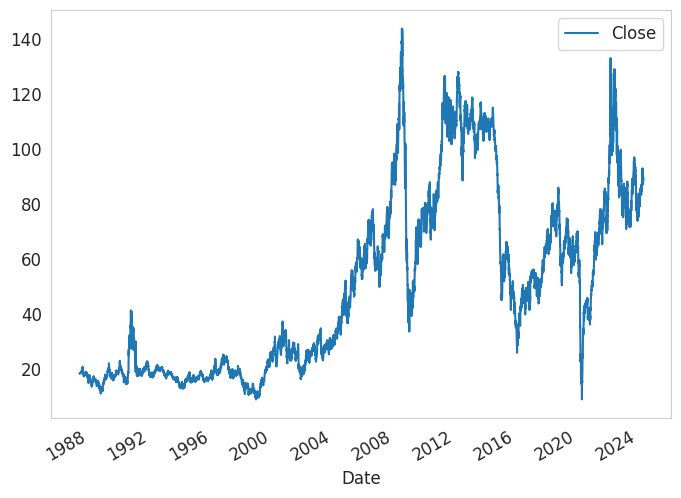

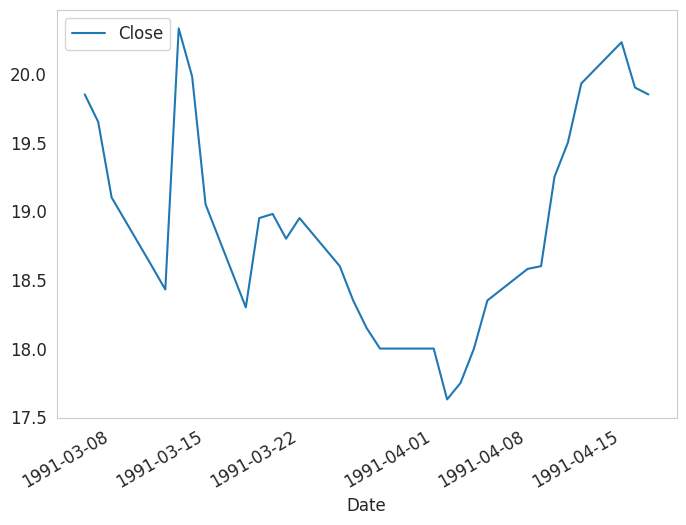

In [5]:
plot_cols = ['Close']
plot_features = brent[plot_cols]
plot_features.index = brent.index
_ = plot_features.plot(subplots=True)

plot_features = brent[plot_cols][970:1000]
plot_features.index = brent.index[970:1000]
_ = plot_features.plot(subplots=True)

In [6]:
brent.info()
print('Quantidade de linhas e colunas:', brent.shape)
print('Quantidade de valores nulos:', brent.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9375 entries, 1987-05-20 to 2024-04-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   9375 non-null   float64
dtypes: float64(1)
memory usage: 146.5 KB
Quantidade de linhas e colunas: (9375, 1)
Quantidade de valores nulos: 0


Verificando as estatísticas do conjunto de dados

In [7]:
brent.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,9375.0,49.767643,32.925689,9.1,19.255,42.37,73.73,143.95


Para esse estudo, vamos descartar os valores de Abertura, Máxima, Mínima e de Volume. Iremos considerar apenas os valores de Fechamento ('Close'). 

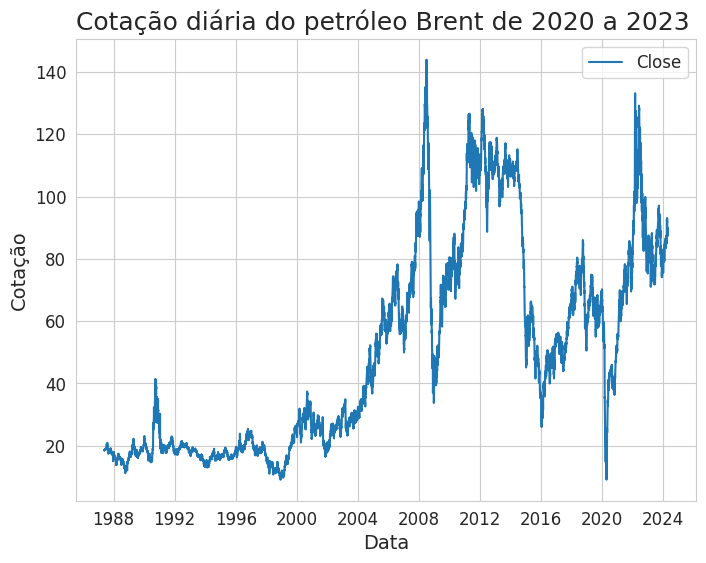

In [8]:
sns.set_palette('tab10')
sns.set_style('whitegrid')
ax = sns.lineplot(brent)
ax.set_title('Cotação diária do petróleo Brent de 2020 a 2023', loc='left', fontsize=18)
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Cotação', fontsize=14)
ax = ax

## Agora vamos fazer uma análise mais profunda usando Redes Neurais

In [9]:
df = brent.copy(deep=True)
dti = df.index
# df['Timestamp'] = dti.map(pd.Timestamp.timestamp)

### Dividindo os dados em Treinamento, Validação e Teste

Iremos usar uma divisão (70%, 20%, 10%) para as amostras de treinamento, validação e teste. Observe que os dados não estão sendo embaralhados de forma aleatória antes da divisão. Isso por dois motivos:
1. Garante que seja possível separar os dados em janelas de amostras consecutivas.
2. Garante que os resultados da validação/teste sejam mais realistas, sendo avaliados nos dados coletados após o treinamento do modelo.

In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalizando os Dados
É importante que a gente escale os dados antes de treinar a rede neural. A normalização é uma forma de colocar os dados na mesma escala: subtraindo a média e dividindo pelo desvio padrão.

A média e o desvio padrão devem ser calculados usando-se apenas os dados de treinamento para que os modelos não tenham acesso aos valores das amostras de validação e de testes (*data leaking*).

In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Text(0.5, 0, 'Data')

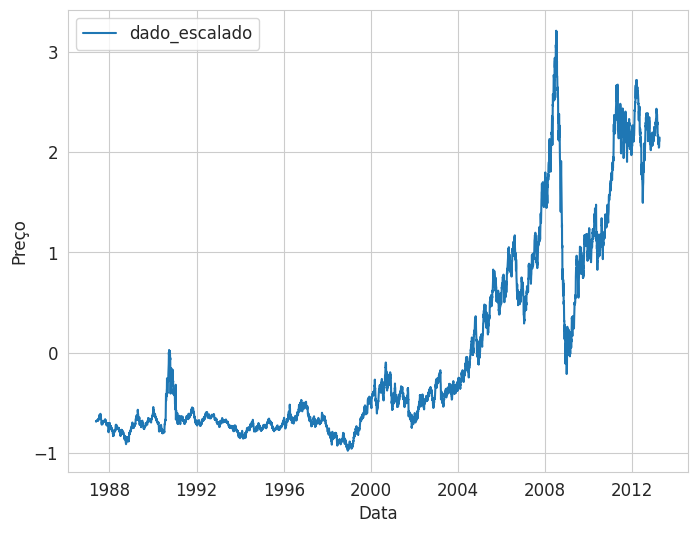

In [12]:
sns.lineplot(x='Date',y='Close', data=train_df, label='dado_escalado')
plt.ylabel('Preço')
plt.xlabel('Data')

<Axes: xlabel='Date', ylabel='Close'>

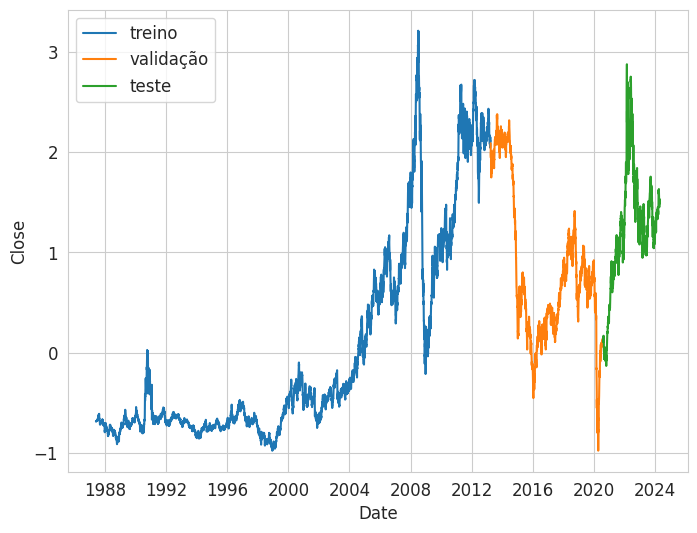

In [13]:
sns.lineplot(x='Date',y='Close', data=train_df, label='treino')
sns.lineplot(x='Date',y='Close', data=val_df, label='validação')
sns.lineplot(x='Date',y='Close', data=test_df, label='teste')

In [14]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

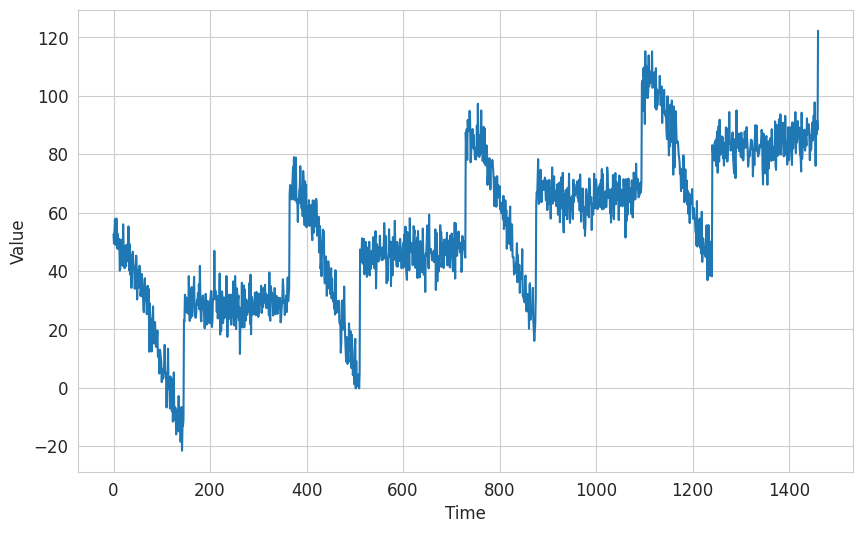

In [15]:
# time = np.arange(4 * 365 + 1)
# 
# slope = 0.05
# baseline = 10
# amplitude = 40
# series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# 
# noise_level = 5
# noise = white_noise(time, noise_level, seed=42)
# 
# series += noise
# 
# plt.figure(figsize=(10, 6))
# plot_series(time, series)
# plt.show()

In [16]:
# split_time = 1000
# time_train = time[:split_time]
# x_train = series[:split_time]
# time_valid = time[split_time:]
# x_valid = series[split_time:]

In [62]:
x_train = np.array(train_df['Close'], dtype=np.float32)
x_train = tf.constant(x_train)
x_valid = np.array(val_df['Close'], dtype=np.float32)
x_valid = tf.constant(x_valid)
x_test = np.array(test_df['Close'], dtype=np.float32)
x_test = tf.constant(x_test)


938

In [46]:
for X_batch, y_batch in sequential_window_dataset(x_train ,30):
    print(X_batch.numpy(), y_batch.numpy())

[[[-0.68236625]
  [-0.6879566 ]
  [-0.6848508 ]
  [-0.683298  ]
  [-0.68236625]
  [-0.683298  ]
  [-0.683298  ]
  [-0.68391913]
  [-0.6817451 ]
  [-0.68081343]
  [-0.6786394 ]
  [-0.67770773]
  [-0.6817451 ]
  [-0.6786394 ]
  [-0.67770773]
  [-0.67770773]
  [-0.68081343]
  [-0.67770773]
  [-0.67398083]
  [-0.66994345]
  [-0.66932225]
  [-0.66932225]
  [-0.66776943]
  [-0.67398083]
  [-0.6786394 ]
  [-0.6801923 ]
  [-0.6683906 ]
  [-0.66621655]
  [-0.6683906 ]
  [-0.6714963 ]]] [[[-0.6879566 ]
  [-0.6848508 ]
  [-0.683298  ]
  [-0.68236625]
  [-0.683298  ]
  [-0.683298  ]
  [-0.68391913]
  [-0.6817451 ]
  [-0.68081343]
  [-0.6786394 ]
  [-0.67770773]
  [-0.6817451 ]
  [-0.6786394 ]
  [-0.67770773]
  [-0.67770773]
  [-0.68081343]
  [-0.67770773]
  [-0.67398083]
  [-0.66994345]
  [-0.66932225]
  [-0.66932225]
  [-0.66776943]
  [-0.67398083]
  [-0.6786394 ]
  [-0.6801923 ]
  [-0.6683906 ]
  [-0.66621655]
  [-0.6683906 ]
  [-0.6714963 ]
  [-0.66311085]]]
[[[-0.66311085]
  [-0.6606263 ]
  [-

In [47]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if(model.name != 'sequential'):
            self.model.reset_states()

In [48]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.InputLayer(batch_shape=(1,None,1)),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule, reset_states])

Epoch 1/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 5.4091 - mae: 5.9062 - learning_rate: 1.0000e-08
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 3.1950 - mae: 3.6754 - learning_rate: 1.1220e-08
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.4911 - mae: 1.9607 - learning_rate: 1.2589e-08
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.6677 - mae: 1.0687 - learning_rate: 1.4125e-08
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3413 - mae: 0.6666 - learning_rate: 1.5849e-08
Epoch 6/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1255 - mae: 0.3779 - learning_rate: 1.7783e-08
Epoch 7/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0123 - mae: 0.0854 - learning_rate: 1.9953e-08
Epoch 8/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0150 - mae: 0.1198 - learning_rate: 2.2387e-08
Epoch 9/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0146 - mae: 0.1182 - learning_rate: 2.5119e-08
E

(1e-08, 0.0001, 0.0, 10.0)

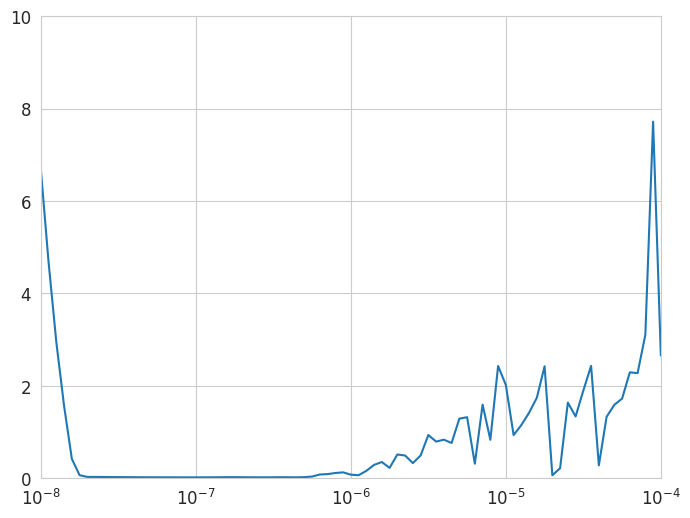

In [53]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 10])

In [54]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.InputLayer(batch_shape=(1,None,1)),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.keras", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 2.6156 - mae: 3.0871 - val_loss: 14.2449 - val_mae: 14.7449
Epoch 2/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 3.5384 - mae: 3.9594 - val_loss: 6.0317 - val_mae: 6.4917
Epoch 3/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 2.4303 - mae: 2.8756 - val_loss: 3.9302 - val_mae: 4.4302
Epoch 4/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.4747 - mae: 0.8378 - val_loss: 7.3618 - val_mae: 7.8618
Epoch 5/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7202 - mae: 2.1472 - val_loss: 1.9528 - val_mae: 2.4247
Epoch 6/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.3761 - mae: 1.7716 - val_loss: 1.0279 - val_mae: 1.5129
Epoch 7/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1812 - mae: 0.4739 - val_loss: 0.1642 - val_mae: 0.4694
Epoch 8/500
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.3131 - mae: 0.6627 - val_loss: 2.7556 - val_mae: 3.2459
Epoch 9/500
218/218 ━━━━━━━━━━━━━━━━━━

In [55]:
model = keras.models.load_model("my_checkpoint.keras", safe_mode=False)

In [130]:
val_array = np.array(val_df['Close'], dtype=np.float32)
val_rnn_forecast = model.predict(val_array[np.newaxis, :, np.newaxis])
val_rnn_forecast = val_rnn_forecast[0, :1875, 0]
val_rnn_forecast.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


(1875,)

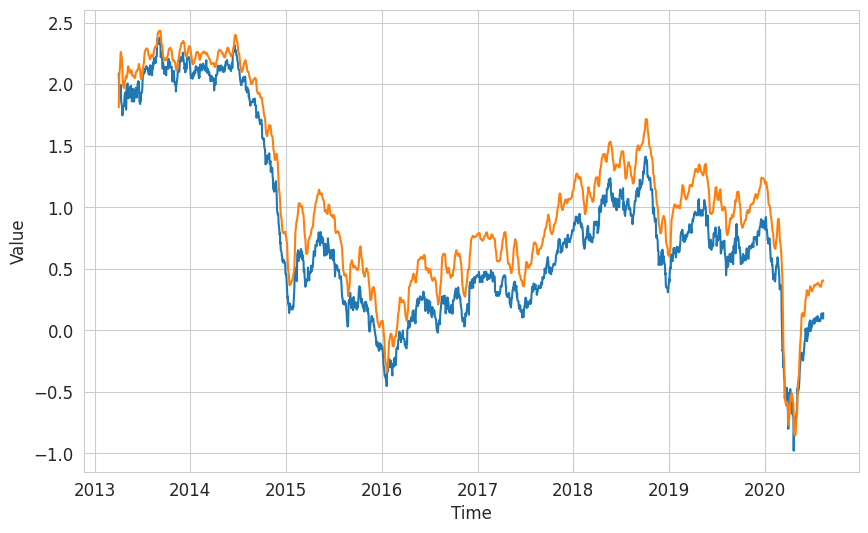

In [131]:
plt.figure(figsize=(10, 6))
plot_series(time=val_df.index, series=val_df['Close'])
plot_series(time=val_df.index, series=val_rnn_forecast)

In [132]:
m = keras.metrics.MeanAbsoluteError()
m.update_state(x_valid, val_rnn_forecast)
m.result().numpy()

0.2639234

In [133]:
test_array = np.array(test_df['Close'], dtype=np.float32)
test_rnn_forecast = model.predict(test_array[np.newaxis, :, np.newaxis])
test_rnn_forecast = test_rnn_forecast[0, :938, 0]
test_rnn_forecast.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


(938,)

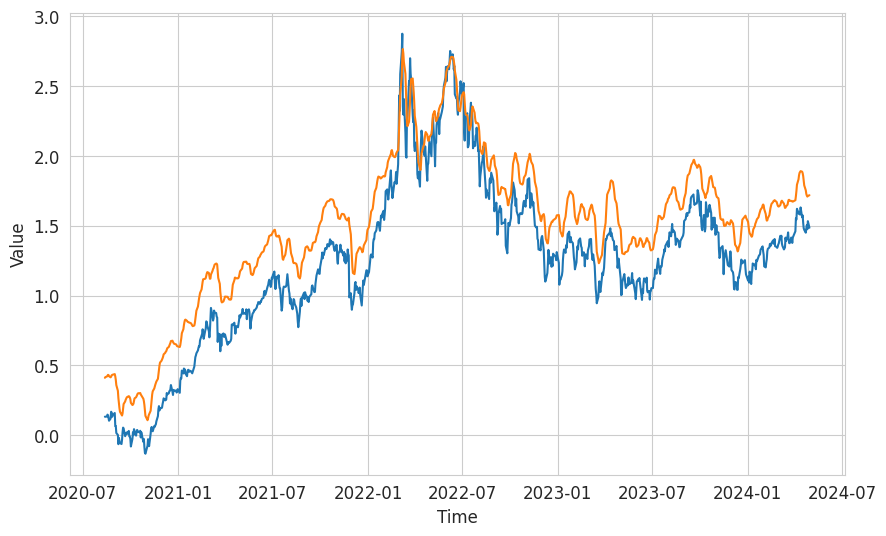

In [134]:
plt.figure(figsize=(10, 6))
plot_series(time=test_df.index, series=test_df['Close'])
plot_series(time=test_df.index, series=test_rnn_forecast)

In [135]:
m = keras.metrics.MeanAbsoluteError()
m.update_state(x_test, test_rnn_forecast)
m.result().numpy()

0.26619303

## Trabalhando com Janelas de Dados
Os modelos neste trabalho farão um conjunto de previsões com base en uma janela de amostras consecutivas dos dados.

A principais características (features) das janelas de entrada são:
    - A largura (*width*), das janelas de entrada e dos labels.
    - O deslocamento (*offset*) entre eles.
    - E quais features serão usadas como input, labels, ou ambos.

Iremos construir e avaliar uma variedade de modelos (incluindo modelos Lineares, DNN, CNN e RNN), e usar duas abordagens:
    - Previsões de *Saída-Única (Single-output)* e *Saída-Múltipla (multi-output)*
    - Previsões de *Passos de Tempo Únicos (Single-Time-Step)* e de *Passos de Tempo Múltiplos (multi-time-step)*
1. Por exemplo, para fazer uma única previsão 24 períodos de tempo no futuro, com base em 24 períodos de histórico, podemos definir uma janela como esta:

    ![Uma previsão de 24 períodos de tempo no futuro](images/raw_window_24h.png)
  
2. Um modelo que faz uma previsão de um único período no futuro com base em 6 períodos de histórico, precisaria de uma janela como esta:

    ![Uma previsão com 6 períodos de tempo no futuro](images/raw_window_1h.png)

Iremos utilizar a definição da classe `WindowGenerator` que está disponível no tutorial. Esta classe pode:

1. Manipular os índices e deslocamentos conforme mostrado nos diagramas acima.
2. Dividir janelas de recursos em pares (features, labels).
3. Plotar o conteúdo das janelas resultantes.
4. Gerar lotes dessas janelas com eficiência a partir dos dados de treinamento, validação e teste, usando tf.data.Dataset.


### 1. Calculando os Indexes and Offsets
No método `__init__` está toda a lógica para inicialização dos índices e rótulos.

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Aqui está o código para criar as duas janelas descritas nos exemplos anteriores:

### 2. Dividindo os dados
O método `split_window` divide o dataset em dois conjuntos, um de entradas e outro de rótulos

In [ ]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

### 3. Plotando os dados
E agora um método de plotagem que permite a visualização da janela dividia:

In [ ]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Tempo (d)')

WindowGenerator.plot = plot

### 4. Criando os Datasets do TensorFlow: tf.data.Dataset
Finalmente, este método `make_dataset` recebe um DataFrame de série temporal e o converte em um `tf.data.Dataset` de `(input_window, label_window)` usando a função `tf.keras.utils.timeseries_dataset_from_array`:

In [ ]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

E como dito anteriormente, o objeto `WindowGenerator` armazena os dados de treinamento, validação e teste.
E para acessá-los como um `tf.data.Dataset` usamos as propriedades `train`, `val` e `test`:  

In [ ]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
val_performance = {}
performance = {}

In [ ]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers.
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
conv_window = WindowGenerator(
    input_width=30,
    label_width=30,
    shift=1,
    label_columns=['Close'])

conv_window.plot()

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

In [ ]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

Since this task is to predict 30 days into the future, given 30 days of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

In [ ]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

#### LSTM RNN Forecasting

In [ ]:
OUT_STEPS = 32
multi_window = WindowGenerator(input_width=32,
                               label_width=1,
                               shift=1)

multi_window.plot()
multi_window

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
import warnings
warnings.filterwarnings('always')

data = np.array(train_df['Close'], dtype=np.float32)

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(20).prefetch(1)

teste = sequential_window_dataset(data, 100)

class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        print(model.name)
        if(model.name=='sequential'):
            print(model.name)
        else:
            self.model.reset_states()

model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.Dense(1),
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(teste, epochs=100, callbacks=[lr_schedule, reset_states])

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [ ]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [ ]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Now, train the model:

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps.

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')

The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.
